# Building and deploying machine learning solutions with Vertex AI: Challenge Lab

This Challenge Lab is recommended for students who have enrolled in the [**Building and deploying machine learning solutions with Vertex AI**](). You will be given a scenario and a set of tasks. Instead of following step-by-step instructions, you will use the skills learned from the labs in the quest to figure out how to complete the tasks on your own! An automated scoring system (shown on the Qwiklabs lab instructions page) will provide feedback on whether you have completed your tasks correctly.

When you take a Challenge Lab, you will not be taught Google Cloud concepts. To build the solution to the challenge presented, use skills learned from the labs in the Quest this challenge lab is part of. You are expected to extend your learned skills and complete all the **`TODO:`** comments in this notebook.

Are you ready for the challenge?

## Scenario

You were recently hired as a Machine Learning Engineer at a startup movie review website. Your manager has tasked you with building a machine learning model to classify the sentiment of user movie reviews as positive or negative. These predictions will be used as an input in downstream movie rating systems and to surface top supportive and critical reviews on the movie website application. The challenge: your business requirements are that you have just 6 weeks to productionize a model that achieves great than 75% accuracy to improve upon an existing bootstrapped solution. Furthermore, after doing some exploratory analysis in your startup's data warehouse, you found that you only have a small dataset of 50k text reviews to build a higher performing solution.

To build and deploy a high performance machine learning model with limited data quickly, you will walk through training and deploying a custom TensorFlow BERT sentiment classifier for online predictions on Google Cloud's [Vertex AI](https://cloud.google.com/vertex-ai) platform. Vertex AI is Google Cloud's next generation machine learning development platform where you can leverage the latest ML pre-built components and AutoML to significantly enhance your development productivity, scale your workflow and decision making with your data, and accelerate time to value.

![Vertex AI: Challenge Lab](./images/vertex-challenge-lab.png "Vertex Challenge Lab")

First, you will progress through a typical experimentation workflow where you will build your model from pre-trained BERT components from TF-Hub and `tf.keras` classification layers to train and evaluate your model in a Vertex Notebook. You will then package your model code into a Docker container to train on Google Cloud's Vertex AI. Lastly, you will define and run a Kubeflow Pipeline on Vertex Pipelines that trains and deploys your model to a Vertex Endpoint that you will query for online predictions.

## Learning objectives

* Train a TensorFlow model locally in a hosted [**Vertex Notebook**](https://cloud.google.com/vertex-ai/docs/general/notebooks?hl=sv).
* Containerize your training code with [**Cloud Build**](https://cloud.google.com/build) and push it to [**Google Cloud Artifact Registry**](https://cloud.google.com/artifact-registry).
* Define a pipeline using the [**Kubeflow Pipelines (KFP) V2 SDK**](https://www.kubeflow.org/docs/components/pipelines/sdk/v2/v2-compatibility) to train and deploy your model on [**Vertex Pipelines**](https://cloud.google.com/vertex-ai/docs/pipelines).
* Query your model on a [**Vertex Endpoint**](https://cloud.google.com/vertex-ai/docs/predictions/getting-predictions) using online predictions.

## Setup

### Define constants

In [1]:
# Add installed library dependencies to Python PATH variable.
PATH=%env PATH
%env PATH={PATH}:/home/jupyter/.local/bin

env: PATH=/usr/local/cuda/bin:/opt/conda/bin:/opt/conda/condabin:/usr/local/bin:/usr/bin:/bin:/usr/local/games:/usr/games:/home/jupyter/.local/bin


In [2]:
# Retrieve and set PROJECT_ID and REGION environment variables.
# TODO: fill in PROJECT_ID.
PROJECT_ID = "qwiklabs-gcp-01-ad0ae90ffc7a"
REGION = "us-central1"

In [3]:
# TODO: Create a globally unique Google Cloud Storage bucket for artifact storage.
GCS_BUCKET = "gs://qwiklabs-gcp-01-ad0ae90ffc7a-vertex-challenge-lab"

In [4]:
!gsutil mb -l $REGION $GCS_BUCKET

Creating gs://qwiklabs-gcp-01-ad0ae90ffc7a-vertex-challenge-lab/...


### Import libraries

In [5]:
import os
import shutil
import logging

# TensorFlow model building libraries.
import tensorflow as tf
import tensorflow_text as text
import tensorflow_hub as hub

# Re-create the AdamW optimizer used in the original BERT paper.
from official.nlp import optimization  

# Libraries for data and plot model training metrics.
import pandas as pd
import matplotlib.pyplot as plt

# Import the Vertex AI Python SDK.
from google.cloud import aiplatform as vertexai

/opt/conda/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.8.0 and strictly below 2.11.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.4 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


### Initialize Vertex AI Python SDK

Initialize the Vertex AI Python SDK with your GCP Project, Region, and Google Cloud Storage Bucket.

In [6]:
vertexai.init(project=PROJECT_ID, location=REGION, staging_bucket=GCS_BUCKET)

## Build and train your model locally in a Vertex Notebook

Note: this lab adapts and extends the official [TensorFlow BERT text classification tutorial](https://www.tensorflow.org/text/tutorials/classify_text_with_bert) to utilize Vertex AI services. See the tutorial for additional coverage on fine-tuning BERT models using TensorFlow.

### Lab dataset

In this lab, you will use the [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment) that contains the text of 50,000 movie reviews from the Internet Movie Database. These are split into 25,000 reviews for training and 25,000 reviews for testing. The training and testing sets are balanced, meaning they contain an equal number of positive and negative reviews. Data ingestion and processing code has been provided for you below:

### Import dataset

In [7]:
DATA_URL = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
LOCAL_DATA_DIR = "."

In [8]:
def download_data(data_url, local_data_dir):
    """Download dataset.
    Args:
      data_url(str): Source data URL path.
      local_data_dir(str): Local data download directory path.
    Returns:
      dataset_dir(str): Local unpacked data directory path.
    """
    if not os.path.exists(local_data_dir):
        os.makedirs(local_data_dir)
    
    dataset = tf.keras.utils.get_file(
      fname="aclImdb_v1.tar.gz",
      origin=data_url,
      untar=True,
      cache_dir=local_data_dir,
      cache_subdir="")
    
    dataset_dir = os.path.join(os.path.dirname(dataset), "aclImdb")
    
    train_dir = os.path.join(dataset_dir, "train")
    
    # Remove unused folders to make it easier to load the data.
    remove_dir = os.path.join(train_dir, "unsup")
    shutil.rmtree(remove_dir)
    
    return dataset_dir

In [9]:
DATASET_DIR = download_data(data_url=DATA_URL, local_data_dir=LOCAL_DATA_DIR)

84140032/84125825 [==============================] - 1s 0us/step


In [10]:
# Create a dictionary to iteratively add data pipeline and model training hyperparameters.
HPARAMS = {
    # Set a random sampling seed to prevent data leakage in data splits from files.
    "seed": 42,
    # Number of training and inference examples.
    "batch-size": 32
}

In [11]:
def load_datasets(dataset_dir, hparams):
    """Load pre-split tf.datasets.
    Args:
      hparams(dict): A dictionary containing model training arguments.
    Returns:
      raw_train_ds(tf.dataset): Train split dataset (20k examples).
      raw_val_ds(tf.dataset): Validation split dataset (5k examples).
      raw_test_ds(tf.dataset): Test split dataset (25k examples).
    """    

    raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
        os.path.join(dataset_dir, 'train'),
        batch_size=hparams['batch-size'],
        validation_split=0.2,
        subset='training',
        seed=hparams['seed'])    

    raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
        os.path.join(dataset_dir, 'train'),
        batch_size=hparams['batch-size'],
        validation_split=0.2,
        subset='validation',
        seed=hparams['seed'])

    raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
        os.path.join(dataset_dir, 'test'),
        batch_size=hparams['batch-size'])
    
    return raw_train_ds, raw_val_ds, raw_test_ds

In [12]:
raw_train_ds, raw_val_ds, raw_test_ds = load_datasets(DATASET_DIR, HPARAMS)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


2022-09-23 03:36:33.378815: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2022-09-23 03:36:33.378860: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-23 03:36:33.378882: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (vertex-ai-challenge): /proc/driver/nvidia/version does not exist
2022-09-23 03:36:33.379369: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [13]:
AUTOTUNE = tf.data.AUTOTUNE
CLASS_NAMES = raw_train_ds.class_names

train_ds = raw_train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = raw_val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = raw_test_ds.prefetch(buffer_size=AUTOTUNE)

Let's print a few example reviews:

In [14]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Review {i}: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({CLASS_NAMES[label]})')

Review 0: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label : 0 (neg)
Review 1: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as 

2022-09-23 03:36:42.862873: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


### Choose a pre-trained BERT model to fine-tune for higher accuracy

[**Bidirectional Encoder Representations from Transformers (BERT)**](https://arxiv.org/abs/1810.04805v2) is a transformer-based text representation model pre-trained on massive datasets (3+ billion words) that can be fine-tuned for state-of-the art results on many natural language processing (NLP) tasks. Since release in 2018 by Google researchers, its has transformed the field of NLP research and come to form a core part of significant improvements to [Google Search](https://www.blog.google/products/search/search-language-understanding-bert). 

To meet your business requirements of achieving higher accuracy on a small dataset (20k training examples), you will use a technique called transfer learning to combine a pre-trained BERT encoder and classification layers to fine tune a new higher performing model for binary sentiment classification.

For this lab, you will use a smaller BERT model that trades some accuracy for faster training times.

The Small BERT models are instances of the original BERT architecture with a smaller number L of layers (i.e., residual blocks) combined with a smaller hidden size H and a matching smaller number A of attention heads, as published by

Iulia Turc, Ming-Wei Chang, Kenton Lee, Kristina Toutanova: ["Well-Read Students Learn Better: On the Importance of Pre-training Compact Models"](https://arxiv.org/abs/1908.08962), 2019.

They have the same general architecture but fewer and/or smaller Transformer blocks, which lets you explore tradeoffs between speed, size and quality.

The following preprocessing and encoder models in the TensorFlow 2 SavedModel format use the implementation of BERT from the [TensorFlow Models Github repository](https://github.com/tensorflow/models/tree/master/official/nlp/bert) with the trained weights released by the authors of Small BERT.

In [15]:
HPARAMS.update({
    # TF Hub BERT modules.
    "tfhub-bert-preprocessor": "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "tfhub-bert-encoder": "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/2",
})

Text inputs need to be transformed to numeric token ids and arranged in several Tensors before being input to BERT. TensorFlow Hub provides a matching preprocessing model for each of the BERT models discussed above, which implements this transformation using TF ops from the TF.text library. Since this text preprocessor is a TensorFlow model, It can be included in your model directly.

For fine-tuning, you will use the same optimizer that BERT was originally trained with: the "Adaptive Moments" (Adam). This optimizer minimizes the prediction loss and does regularization by weight decay (not using moments), which is also known as [AdamW](https://arxiv.org/abs/1711.05101).

For the learning rate `initial-learning-rate`, you will use the same schedule as BERT pre-training: linear decay of a notional initial learning rate, prefixed with a linear warm-up phase over the first 10% of training steps `n_warmup_steps`. In line with the BERT paper, the initial learning rate is smaller for fine-tuning.

In [16]:
HPARAMS.update({
    # Model training hyperparameters for fine tuning and regularization.
    "epochs": 3,
    "initial-learning-rate": 3e-5,
    "dropout": 0.1 
})

In [17]:
epochs = HPARAMS['epochs']
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
n_train_steps = steps_per_epoch * epochs
n_warmup_steps = int(0.1 * n_train_steps)    

OPTIMIZER = optimization.create_optimizer(init_lr=HPARAMS['initial-learning-rate'],
                                          num_train_steps=n_train_steps,
                                          num_warmup_steps=n_warmup_steps,
                                          optimizer_type='adamw')

INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


### Build and compile a TensorFlow BERT sentiment classifier

Next, you will define and compile your model by assembling pre-built TF-Hub components and tf.keras layers.

In [18]:
def build_text_classifier(hparams, optimizer):
    """Define and compile a TensorFlow BERT sentiment classifier.
    Args:
      hparams(dict): A dictionary containing model training arguments.
    Returns:
      model(tf.keras.Model): A compiled TensorFlow model.
    """
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    # TODO: Add a hub.KerasLayer for BERT text preprocessing using the hparams dict. 
    # Name the layer 'preprocessing' and store in the variable preprocessor.
    preprocessor = hub.KerasLayer(hparams['tfhub-bert-preprocessor'],name='preprocessing')
    
    encoder_inputs = preprocessor(text_input)
    # TODO: Add a trainable hub.KerasLayer for BERT text encoding using the hparams dict.
    # Name the layer 'BERT_encoder' and store in the variable encoder.
    encoder = hub.KerasLayer(hparams['tfhub-bert-encoder'], trainable=True, name='BERT_encoder')


    outputs = encoder(encoder_inputs)
    # For the fine-tuning you are going to use the `pooled_output` array which represents 
    # each input sequence as a whole. The shape is [batch_size, H]. 
    # You can think of this as an embedding for the entire movie review.
    classifier = outputs['pooled_output']
    # Add dropout to prevent overfitting during model fine-tuning.
    classifier = tf.keras.layers.Dropout(hparams['dropout'], name='dropout')(classifier)
    classifier = tf.keras.layers.Dense(1, activation=None, name='classifier')(classifier)
    model = tf.keras.Model(text_input, classifier, name='bert-sentiment-classifier')
    
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    metrics = tf.metrics.BinaryAccuracy()    
    
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=metrics)    
    
    return model

In [19]:
model = build_text_classifier(HPARAMS, OPTIMIZER)

INFO:absl:Using /tmp/tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'.
INFO:absl:Downloaded https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3, Total size: 1.96MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/2'.
INFO:absl:Downloaded https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/2, Total size: 19.27MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/2'.


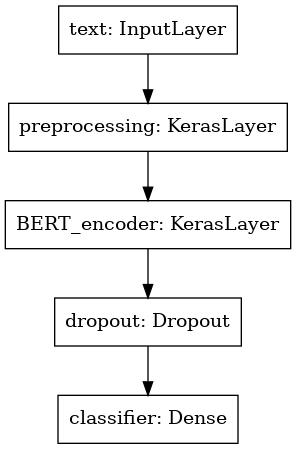

In [20]:
# Visualize your fine-tuned BERT sentiment classifier.
tf.keras.utils.plot_model(model)

In [21]:
TEST_REVIEW = ['this is such an amazing movie!']

In [22]:
BERT_RAW_RESULT = model(tf.constant(TEST_REVIEW))
print(BERT_RAW_RESULT)

tf.Tensor([[-1.6907157]], shape=(1, 1), dtype=float32)


### Train and evaluate your BERT sentiment classifier

In [23]:
HPARAMS.update({
    # TODO: Save your BERT sentiment classifier locally. 
    # Hint: Save it to './bert-sentiment-classifier-local'. Note the key name in model.save().
    "model-dir": "./bert-sentiment-classifier-local"

    
})

**Note:** training your model locally will take about 8-10 minutes.

In [24]:
def train_evaluate(hparams):
    """Train and evaluate TensorFlow BERT sentiment classifier.
    Args:
      hparams(dict): A dictionary containing model training arguments.
    Returns:
      history(tf.keras.callbacks.History): Keras callback that records training event history.
    """
    # dataset_dir = download_data(data_url, local_data_dir)
    raw_train_ds, raw_val_ds, raw_test_ds = load_datasets(DATASET_DIR, hparams)
    
    train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
    val_ds = raw_val_ds.cache().prefetch(buffer_size=AUTOTUNE)
    test_ds = raw_test_ds.cache().prefetch(buffer_size=AUTOTUNE)     
    
    epochs = hparams['epochs']
    steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
    n_train_steps = steps_per_epoch * epochs
    n_warmup_steps = int(0.1 * n_train_steps)    
    
    optimizer = optimization.create_optimizer(init_lr=hparams['initial-learning-rate'],
                                              num_train_steps=n_train_steps,
                                              num_warmup_steps=n_warmup_steps,
                                              optimizer_type='adamw')    
    
    mirrored_strategy = tf.distribute.MirroredStrategy()
    with mirrored_strategy.scope():
        model = build_text_classifier(hparams=hparams, optimizer=optimizer)
    
    logging.info(model.summary())
        
    history = model.fit(x=train_ds,
                        validation_data=val_ds,
                        epochs=epochs)  
    
    logging.info("Test accuracy: %s", model.evaluate(test_ds))

    # Export Keras model in TensorFlow SavedModel format.
    model.save(hparams['model-dir'])
    
    return history

Based on the `History` object returned by `model.fit()`. You can plot the training and validation loss for comparison, as well as the training and validation accuracy:

In [25]:
history = train_evaluate(HPARAMS)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.
INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Model: "bert-sentiment-classifier"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
preprocessing (KerasLayer)      {'input_type_ids': ( 0           text[0][0]                       
_____

2022-09-23 03:37:45.519941: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}

2022-09-23 03:37:45.561046: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


625/625 [==============================] - ETA: 0s - loss: 0.6147 - binary_accuracy: 0.6338

2022-09-23 03:40:39.342978: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}

2022-09-23 03:40:39.382627: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


625/625 [==============================] - 190s 294ms/step - loss: 0.6147 - binary_accuracy: 0.6338 - val_loss: 0.4936 - val_binary_accuracy: 0.7536
Epoch 2/3
625/625 [==============================] - ETA: 0s - loss: 0.4833 - binary_accuracy: 0.7562

2022-09-23 03:43:42.960207: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


625/625 [==============================] - 182s 291ms/step - loss: 0.4833 - binary_accuracy: 0.7562 - val_loss: 0.4477 - val_binary_accuracy: 0.7792
Epoch 3/3
625/625 [==============================] - ETA: 0s - loss: 0.4480 - binary_accuracy: 0.7804

2022-09-23 03:46:44.266319: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


  1/782 [..............................] - ETA: 2:22 - loss: 0.3668 - binary_accuracy: 0.8125

2022-09-23 03:46:58.401850: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}



782/782 [==============================] - 74s 94ms/step - loss: 0.4495 - binary_accuracy: 0.7791
INFO:root:Test accuracy: [0.4495035409927368, 0.7791200280189514]


2022-09-23 03:48:13.101091: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./bert-sentiment-classifier-local/assets
INFO:tensorflow:Assets written to: ./bert-sentiment-classifier-local/assets


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


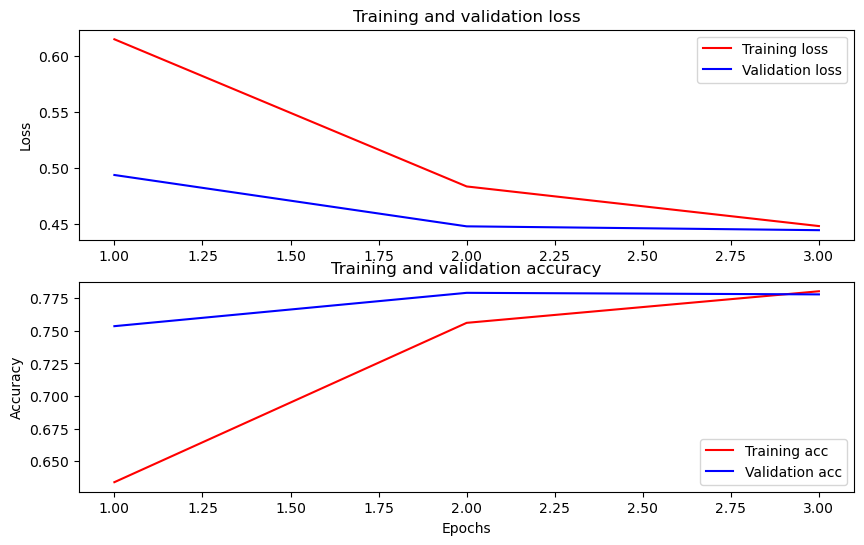

In [26]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right');

In this plot, the red lines represent the training loss and accuracy, and the blue lines are the validation loss and accuracy. Based on the plots above, you should see model accuracy of around 78-80% which exceeds your business requirements target of greater than 75% accuracy.

## Containerize your model code

Now that you trained and evaluated your model locally in a Vertex Notebook as part of an experimentation workflow, your next step is to train and deploy your model on Google Cloud's Vertex AI platform.

To train your BERT classifier on Google Cloud, you will you will package your Python training scripts and write a Dockerfile that contains instructions on your ML model code, dependencies, and execution instructions. You will build your custom container with Cloud Build, whose instructions are specified in `cloudbuild.yaml` and publish your container to your Artifact Registry. This workflow gives you the opportunity to use the same container to run as part of a portable and scalable [Vertex Pipelines](https://cloud.google.com/vertex-ai/docs/pipelines/introduction) workflow. 


You will walk through creating the following project structure for your ML mode code:
```
|--/bert-sentiment-classifier
   |--/trainer
      |--__init__.py
      |--model.py
      |--task.py
   |--Dockerfile
   |--cloudbuild.yaml
   |--requirements.txt
```

### 1. Write a `model.py` training script

First, you will tidy up your local TensorFlow model training code from above into a training script.

In [27]:
MODEL_DIR = "bert-sentiment-classifier"

In [28]:
%%writefile {MODEL_DIR}/trainer/model.py
import os
import shutil
import logging

import tensorflow as tf
import tensorflow_text as text
import tensorflow_hub as hub
from official.nlp import optimization

DATA_URL = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
LOCAL_DATA_DIR = './tmp/data'
AUTOTUNE = tf.data.AUTOTUNE


def download_data(data_url, local_data_dir):
    """Download dataset.
    Args:
      data_url(str): Source data URL path.
      local_data_dir(str): Local data download directory path.
    Returns:
      dataset_dir(str): Local unpacked data directory path.
    """
    if not os.path.exists(local_data_dir):
        os.makedirs(local_data_dir)
    
    dataset = tf.keras.utils.get_file(
      fname='aclImdb_v1.tar.gz',
      origin=data_url,
      untar=True,
      cache_dir=local_data_dir,
      cache_subdir="")
    
    dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
    
    train_dir = os.path.join(dataset_dir, 'train')
    
    # Remove unused folders to make it easier to load the data.
    remove_dir = os.path.join(train_dir, 'unsup')
    shutil.rmtree(remove_dir)
    
    return dataset_dir


def load_datasets(dataset_dir, hparams):
    """Load pre-split tf.datasets.
    Args:
      hparams(dict): A dictionary containing model training arguments.
    Returns:
      raw_train_ds(tf.dataset): Train split dataset (20k examples).
      raw_val_ds(tf.dataset): Validation split dataset (5k examples).
      raw_test_ds(tf.dataset): Test split dataset (25k examples).
    """    

    raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
        os.path.join(dataset_dir, 'train'),
        batch_size=hparams['batch-size'],
        validation_split=0.2,
        subset='training',
        seed=hparams['seed'])    

    raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
        os.path.join(dataset_dir, 'train'),
        batch_size=hparams['batch-size'],
        validation_split=0.2,
        subset='validation',
        seed=hparams['seed'])

    raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
        os.path.join(dataset_dir, 'test'),
        batch_size=hparams['batch-size'])
    
    return raw_train_ds, raw_val_ds, raw_test_ds


def build_text_classifier(hparams, optimizer):
    """Define and compile a TensorFlow BERT sentiment classifier.
    Args:
      hparams(dict): A dictionary containing model training arguments.
    Returns:
      model(tf.keras.Model): A compiled TensorFlow model.
    """
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    # TODO: Add a hub.KerasLayer for BERT text preprocessing using the hparams dict. 
    # Name the layer 'preprocessing' and store in the variable preprocessor.
    preprocessor = hub.KerasLayer(hparams['tfhub-bert-preprocessor'], name='preprocessing')
    encoder_inputs = preprocessor(text_input)
    # TODO: Add a trainable hub.KerasLayer for BERT text encoding using the hparams dict.
    # Name the layer 'BERT_encoder' and store in the variable encoder.
    encoder = hub.KerasLayer(hparams['tfhub-bert-encoder'], trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    # For the fine-tuning you are going to use the `pooled_output` array which represents 
    # each input sequence as a whole. The shape is [batch_size, H]. 
    # You can think of this as an embedding for the entire movie review.
    classifier = outputs['pooled_output']
    # Add dropout to prevent overfitting during model fine-tuning.
    classifier = tf.keras.layers.Dropout(hparams['dropout'], name='dropout')(classifier)
    classifier = tf.keras.layers.Dense(1, activation=None, name='classifier')(classifier)
    model = tf.keras.Model(text_input, classifier, name='bert-sentiment-classifier')
    
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    metrics = tf.metrics.BinaryAccuracy()    
    
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=metrics)    
    
    return model


def train_evaluate(hparams):
    """Train and evaluate TensorFlow BERT sentiment classifier.
    Args:
      hparams(dict): A dictionary containing model training arguments.
    Returns:
      history(tf.keras.callbacks.History): Keras callback that records training event history.
    """
    dataset_dir = download_data(data_url=DATA_URL, 
                                local_data_dir=LOCAL_DATA_DIR)
    
    raw_train_ds, raw_val_ds, raw_test_ds = load_datasets(dataset_dir=dataset_dir,
                                                          hparams=hparams)
    
    train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
    val_ds = raw_val_ds.cache().prefetch(buffer_size=AUTOTUNE)
    test_ds = raw_test_ds.cache().prefetch(buffer_size=AUTOTUNE)     
    
    epochs = hparams['epochs']
    steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
    n_train_steps = steps_per_epoch * epochs
    n_warmup_steps = int(0.1 * n_train_steps)    
    
    optimizer = optimization.create_optimizer(init_lr=hparams['initial-learning-rate'],
                                              num_train_steps=n_train_steps,
                                              num_warmup_steps=n_warmup_steps,
                                              optimizer_type='adamw')    
    
    mirrored_strategy = tf.distribute.MirroredStrategy()
    with mirrored_strategy.scope():
        model = build_text_classifier(hparams=hparams, optimizer=optimizer)
        logging.info(model.summary())
        
    history = model.fit(x=train_ds,
                        validation_data=val_ds,
                        epochs=epochs)  
    
    logging.info("Test accuracy: %s", model.evaluate(test_ds))

    # Export Keras model in TensorFlow SavedModel format.
    model.save(hparams['model-dir'])
    
    return history

Overwriting bert-sentiment-classifier/trainer/model.py


### 2. Write a `task.py` file as an entrypoint to your custom model container

In [29]:
%%writefile {MODEL_DIR}/trainer/task.py

import os
import argparse

from trainer import model

if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    # Vertex custom container training args. These are set by Vertex AI during training but can also be overwritten.
    parser.add_argument('--model-dir', dest='model-dir',
                        default=os.environ['AIP_MODEL_DIR'], type=str, help='GCS URI for saving model artifacts.')

    # Model training args.
    parser.add_argument('--tfhub-bert-preprocessor', dest='tfhub-bert-preprocessor', 
                        default='https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3', type=str, help='TF-Hub URL.')
    parser.add_argument('--tfhub-bert-encoder', dest='tfhub-bert-encoder', 
                        default='https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/2', type=str, help='TF-Hub URL.')    
    parser.add_argument('--initial-learning-rate', dest='initial-learning-rate', default=3e-5, type=float, help='Learning rate for optimizer.')
    parser.add_argument('--epochs', dest='epochs', default=3, type=int, help='Training iterations.')    
    parser.add_argument('--batch-size', dest='batch-size', default=32, type=int, help='Number of examples during each training iteration.')    
    parser.add_argument('--dropout', dest='dropout', default=0.1, type=float, help='Float percentage of DNN nodes [0,1] to drop for regularization.')    
    parser.add_argument('--seed', dest='seed', default=42, type=int, help='Random number generator seed to prevent overlap between train and val sets.')
    
    args = parser.parse_args()
    hparams = args.__dict__

    model.train_evaluate(hparams)

Overwriting bert-sentiment-classifier/trainer/task.py


### 3. Write a `Dockerfile` for your custom model container

Third, you will write a `Dockerfile` that contains instructions to package your model code in `bert-sentiment-classifier` as well as specifies your model code's dependencies needed for execution together in a Docker container.

In [30]:
%%writefile {MODEL_DIR}/Dockerfile
# Specifies base image and tag.
# https://cloud.google.com/vertex-ai/docs/training/pre-built-containers
FROM us-docker.pkg.dev/vertex-ai/training/tf-cpu.2-6:latest

# Sets the container working directory.
WORKDIR /root

# Copies the requirements.txt into the container to reduce network calls.
COPY requirements.txt .

# Installs additional packages.
RUN pip3 install -U -r requirements.txt

# b/203105209 Removes unneeded file from TF2.5 CPU image for python_module CustomJob training. 
# Will be removed on subsequent public Vertex images.
RUN rm -rf /var/sitecustomize/sitecustomize.py

# Copies the trainer code to the docker image.
COPY . /trainer

# Sets the container working directory.
WORKDIR /trainer

# Sets up the entry point to invoke the trainer.
ENTRYPOINT ["python", "-m", "trainer.task"]

Overwriting bert-sentiment-classifier/Dockerfile


### 4. Write a `requirements.txt` file to specify additional ML code dependencies

These are additional dependencies for your model code not included in the pre-built Vertex TensorFlow images such as TF-Hub, TensorFlow AdamW optimizer, and TensorFlow Text needed for importing and working with pre-trained TensorFlow BERT models.

In [31]:
%%writefile {MODEL_DIR}/requirements.txt
tf-models-official==2.6.0
tensorflow-text==2.6.0
tensorflow-hub==0.12.0

Overwriting bert-sentiment-classifier/requirements.txt


## Use Cloud Build to build and submit your model container to Google Cloud Artifact Registry

Next, you will use [Cloud Build](https://cloud.google.com/build) to build and upload your custom TensorFlow model container to [Google Cloud Artifact Registry](https://cloud.google.com/artifact-registry).

Cloud Build brings reusability and automation to your ML experimentation by enabling you to reliably build, test, and deploy your ML model code as part of a CI/CD workflow. Artifact Registry provides a centralized repository for you to store, manage, and secure your ML container images. This will allow you to securely share your ML work with others and reproduce experiment results.

**Note**: the initial build and submit step will take about 16 minutes but Cloud Build is able to take advantage of caching for faster subsequent builds.

### 1. Create Artifact Registry for custom container images

In [32]:
ARTIFACT_REGISTRY="bert-sentiment-classifier"

In [33]:
# TODO: create a Docker Artifact Registry using the gcloud CLI. Note the required respository-format and location flags.
# Documentation link: https://cloud.google.com/sdk/gcloud/reference/artifacts/repositories/create

!gcloud artifacts repositories create {ARTIFACT_REGISTRY} \
--repository-format=docker \
--location={REGION} \
--description="Artifact registry for ML custom training images for sentiment classification"


Create request issued for: [bert-sentiment-classifier]
Waiting for operation [projects/qwiklabs-gcp-01-ad0ae90ffc7a/locations/us-centr
al1/operations/4b26ad06-a78b-42ea-9bd6-0fcdf56783c5] to complete...done.       
Created repository [bert-sentiment-classifier].


### 2. Create `cloudbuild.yaml` instructions

In [34]:
IMAGE_NAME="bert-sentiment-classifier"
IMAGE_TAG="latest"
IMAGE_URI=f"{REGION}-docker.pkg.dev/{PROJECT_ID}/{ARTIFACT_REGISTRY}/{IMAGE_NAME}:{IMAGE_TAG}"

In [35]:
cloudbuild_yaml = f"""steps:
- name: 'gcr.io/cloud-builders/docker'
  args: [ 'build', '-t', '{IMAGE_URI}', '.' ]
images: 
- '{IMAGE_URI}'"""

with open(f"{MODEL_DIR}/cloudbuild.yaml", "w") as fp:
    fp.write(cloudbuild_yaml)

### 3. Build and submit your container image to Artifact Registry using Cloud Build

**Note:** your custom model container will take about 16 minutes initially to build and submit to your Artifact Registry. Artifact Registry is able to take advantage of caching so subsequent builds take about 4 minutes.

In [ ]:
# TODO: use Cloud Build to build and submit your custom model container to your Artifact Registry.
# Documentation link: https://cloud.google.com/sdk/gcloud/reference/builds/submit
# Hint: make sure the config flag is pointed at {MODEL_DIR}/cloudbuild.yaml defined above and you include your model directory.
!gcloud builds submit {MODEL_DIR} --timeout=20m --config {MODEL_DIR}/cloudbuild.yaml



Creating temporary tarball archive of 6 file(s) totalling 8.5 KiB before compression.
Uploading tarball of [bert-sentiment-classifier] to [gs://qwiklabs-gcp-01-ad0ae90ffc7a_cloudbuild/source/1663905094.756177-02f6aa224ddf4b01a1ad4a7d7b4a707d.tgz]
Created [https://cloudbuild.googleapis.com/v1/projects/qwiklabs-gcp-01-ad0ae90ffc7a/locations/global/builds/4041b6ed-ca93-4a43-bd7a-a15ad2167dbf].
Logs are available at [ https://console.cloud.google.com/cloud-build/builds/4041b6ed-ca93-4a43-bd7a-a15ad2167dbf?project=934878701467 ].
----------------------------- REMOTE BUILD OUTPUT ------------------------------
starting build "4041b6ed-ca93-4a43-bd7a-a15ad2167dbf"

FETCHSOURCE
Fetching storage object: gs://qwiklabs-gcp-01-ad0ae90ffc7a_cloudbuild/source/1663905094.756177-02f6aa224ddf4b01a1ad4a7d7b4a707d.tgz#1663905095583597
Copying gs://qwiklabs-gcp-01-ad0ae90ffc7a_cloudbuild/source/1663905094.756177-02f6aa224ddf4b01a1ad4a7d7b4a707d.tgz#1663905095583597...
/ [1 files][  3.4 KiB/  3.4 KiB]     

## Define a pipeline using the KFP V2 SDK

To address your business requirements and get your higher performing model into production to deliver value faster, you will define a pipeline using the [**Kubeflow Pipelines (KFP) V2 SDK**](https://www.kubeflow.org/docs/components/pipelines/sdk/v2/v2-compatibility) to orchestrate the training and deployment of your model on [**Vertex Pipelines**](https://cloud.google.com/vertex-ai/docs/pipelines) below.

In [ ]:
import datetime
# google_cloud_pipeline_components includes pre-built KFP components for interfacing with Vertex AI services.
from google_cloud_pipeline_components import aiplatform as gcc_aip
from kfp.v2 import dsl

In [ ]:
TIMESTAMP=datetime.datetime.now().strftime('%Y%m%d%H%M%S')
DISPLAY_NAME = "bert-sentiment-{}".format(TIMESTAMP)
GCS_BASE_OUTPUT_DIR= f"{GCS_BUCKET}/{MODEL_DIR}-{TIMESTAMP}"

USER = "qwiklabsdemo"  # TODO: change this to your name.
PIPELINE_ROOT = "{}/pipeline_root/{}".format(GCS_BUCKET, USER)

print(f"Model display name: {DISPLAY_NAME}")
print(f"GCS dir for model training artifacts: {GCS_BASE_OUTPUT_DIR}")
print(f"GCS dir for pipeline artifacts: {PIPELINE_ROOT}")

In [ ]:
# Pre-built Vertex model serving container for deployment.
# https://cloud.google.com/vertex-ai/docs/predictions/pre-built-containers
SERVING_IMAGE_URI = "us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-6:latest"

The pipeline consists of three components:

* `CustomContainerTrainingJobRunOp` [(documentation)](https://google-cloud-pipeline-components.readthedocs.io/en/google-cloud-pipeline-components-0.2.0/google_cloud_pipeline_components.aiplatform.html#google_cloud_pipeline_components.aiplatform.CustomContainerTrainingJobRunOp): trains your custom model container using Vertex Training. This is the same as configuring a Vertex Custom Container Training Job using the Vertex Python SDK you covered in the Vertex AI: Qwik Start lab.

*  `EndpointCreateOp` [(documentation)](https://google-cloud-pipeline-components.readthedocs.io/en/google-cloud-pipeline-components-0.2.0/google_cloud_pipeline_components.aiplatform.html#google_cloud_pipeline_components.aiplatform.EndpointCreateOp): Creates a Google Cloud Vertex Endpoint resource that maps physical machine resources with your model to enable it to serve online predictions. Online predictions have low latency requirements; providing resources to the model in advance reduces latency. 

* `ModelDeployOp`[(documentation)](https://google-cloud-pipeline-components.readthedocs.io/en/google-cloud-pipeline-components-0.2.0/google_cloud_pipeline_components.aiplatform.html#google_cloud_pipeline_components.aiplatform.ModelDeployOp): deploys your model to a Vertex Prediction Endpoint for online predictions.

In [ ]:
@dsl.pipeline(name="bert-sentiment-classification", pipeline_root=PIPELINE_ROOT)
def pipeline(
    project: str = PROJECT_ID,
    location: str = REGION,
    staging_bucket: str = GCS_BUCKET,
    display_name: str = DISPLAY_NAME,    
    container_uri: str = IMAGE_URI,
    model_serving_container_image_uri: str = SERVING_IMAGE_URI,    
    base_output_dir: str = GCS_BASE_OUTPUT_DIR,
):
    
    #TODO: add and configure the pre-built KFP CustomContainerTrainingJobRunOp component using
    # the remaining arguments in the pipeline constructor. 
    # Hint: Refer to the component documentation link above if needed as well.
    model_train_evaluate_op = gcc_aip.CustomContainerTrainingJobRunOp(
        # Vertex AI Python SDK authentication parameters.        
        project=project,
        location=location,
        staging_bucket=staging_bucket,
        # WorkerPool arguments.
        replica_count=1,
        machine_type="c2-standard-4",
        # TODO: fill in the remaining arguments from the pipeline constructor.
        
        display_name=display_name,
        container_uri=container_uri,
        model_serving_container_image_uri=model_serving_container_image_uri,
        base_output_dir=GCS_BASE_OUTPUT_DIR,

    )    
    
    # Create a Vertex Endpoint resource in parallel with model training.
    endpoint_create_op = gcc_aip.EndpointCreateOp(
        # Vertex AI Python SDK authentication parameters.
        project=project,
        location=location,
        display_name=display_name
    
    )   
    
    # Deploy your model to the created Endpoint resource for online predictions.
    model_deploy_op = gcc_aip.ModelDeployOp(
        # Link to model training component through output model artifact.
        model=model_train_evaluate_op.outputs["model"],
        # Link to the created Endpoint.
        endpoint=endpoint_create_op.outputs["endpoint"],
        # Define prediction request routing. {"0": 100} indicates 100% of traffic 
        # to the ID of the current model being deployed.
        traffic_split={"0": 100},
        # WorkerPool arguments.        
        dedicated_resources_machine_type="n1-standard-4",
        dedicated_resources_min_replica_count=1,
        dedicated_resources_max_replica_count=2
    )

## Compile the pipeline

In [ ]:
from kfp.v2 import compiler

In [ ]:
compiler.Compiler().compile(
    pipeline_func=pipeline, package_path="bert-sentiment-classification.json"
)

## Run the pipeline on Vertex Pipelines

The `PipelineJob` is configured below and triggered through the `run()` method.

**Note:** This pipeline run will take around 30-40 minutes to train and deploy your model. Follow along with the execution using the URL from the job output below.

In [ ]:
vertex_pipelines_job = vertexai.pipeline_jobs.PipelineJob(
    display_name="bert-sentiment-classification",
    template_path="bert-sentiment-classification.json",
    parameter_values={
        "project": PROJECT_ID,
        "location": REGION,
        "staging_bucket": GCS_BUCKET,
        "display_name": DISPLAY_NAME,        
        "container_uri": IMAGE_URI,
        "model_serving_container_image_uri": SERVING_IMAGE_URI,        
        "base_output_dir": GCS_BASE_OUTPUT_DIR},
    enable_caching=True,
)

In [ ]:
vertex_pipelines_job.run()

## Query deployed model on Vertex Endpoint for online predictions

Finally, you will retrieve the `Endpoint` deployed by the pipeline and use it to query your model for online predictions.

Configure the `Endpoint()` function below with the following parameters:

*  `endpoint_name`: A fully-qualified endpoint resource name or endpoint ID. Example: "projects/123/locations/us-central1/endpoints/456" or "456" when project and location are initialized or passed.
*  `project_id`: GCP project.
*  `location`: GCP region.

Call `predict()` to return a prediction for a test review.

In [ ]:
# Retrieve your deployed Endpoint name from your pipeline.
ENDPOINT_NAME = vertexai.Endpoint.list()[0].name

In [ ]:
#TODO: Generate online predictions using your Vertex Endpoint.

endpoint = vertexai.Endpoint(
endpoint_name=ENDPOINT_NAME,
project=PROJECT_ID,
location=REGION
)

In [ ]:
#TODO: write a movie review to test your model e.g. "The Dark Knight is the best Batman movie!"
test_review = "The Dark Knight is the best Batman movie!"

In [ ]:
# TODO: use your Endpoint to return prediction for your test_review.
prediction = endpoint.predict([test_review])

In [ ]:
print(prediction)

In [ ]:
# Use a sigmoid function to compress your model output between 0 and 1. For binary classification, a threshold of 0.5 is typically applied
# so if the output is >= 0.5 then the predicted sentiment is "Positive" and < 0.5 is a "Negative" prediction.
print(tf.sigmoid(prediction.predictions[0]))

## Next steps

Congratulations! You walked through a full experimentation, containerization, and MLOps workflow on Vertex AI. First, you built, trained, and evaluated a BERT sentiment classifier model in a Vertex Notebook. You then packaged your model code into a Docker container to train on Google Cloud's Vertex AI. Lastly, you defined and ran a Kubeflow Pipeline on Vertex Pipelines that trained and deployed your model container to a Vertex Endpoint that you queried for online predictions.

## License

In [ ]:
# Copyright 2021 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.